In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import flair, torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flair.device = device

In [21]:
from flair.data import Sentence
from flair.models import SequenceTagger
import flair.datasets
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.visual.training_curves import Plotter
import pandas as pd
from tqdm import tqdm
corpus =  flair.datasets.INSPEC()

2020-10-11 21:18:45,504 Reading data from /home/zaki/.flair/datasets/inspec
2020-10-11 21:18:45,504 Train: /home/zaki/.flair/datasets/inspec/train.txt
2020-10-11 21:18:45,505 Dev: /home/zaki/.flair/datasets/inspec/dev.txt
2020-10-11 21:18:45,505 Test: /home/zaki/.flair/datasets/inspec/test.txt


In [ ]:
'''dataset statistics visualization'''

print(len(corpus.train))
print(len(corpus.test))
print(len(corpus.dev))

In [19]:


def get_corpus(corpus_type):
    if(corpus_type=="inspec"):
        corpus =  flair.datasets.INSPEC()
    if(corpus_type=="semeval_2010"):
        corpus =  flair.datasets.SEMEVAL2010()
    if(corpus_type=="semeval_2017"):
        corpus =  flair.datasets.SEMEVAL2017()
        
    return corpus

def get_tag_dictionary(corpus, tag_type):
    tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
    print(tag_dictionary)
    return tag_dictionary

def get_embeddings(embedding_type):
    embedding_types = [
        TransformerWordEmbeddings(embedding_type)
    ]
    embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)
    return embeddings


def initialize_model(tag_type):
    tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                            embeddings=embeddings,
                                            tag_dictionary=tag_dictionary,
                                            tag_type=tag_type,
                                            use_crf=True)      
    return tagger

def plot_curves(path):  
    plotter = Plotter()
    plotter.plot_training_curves(path + "loss.tsv")
    plotter.plot_weights(path + "weights.txt")

In [10]:
corpus = get_corpus("inspec")

tag_dictionary = get_tag_dictionary(corpus, tag_type="keyword")

embeddings = get_embeddings('bert-base-uncased')

tagger = initialize_model(tag_type="keyword")

2020-10-11 20:40:43,999 Reading data from /home/zaki/.flair/datasets/inspec
2020-10-11 20:40:44,000 Train: /home/zaki/.flair/datasets/inspec/train.txt
2020-10-11 20:40:44,000 Dev: /home/zaki/.flair/datasets/inspec/dev.txt
2020-10-11 20:40:44,001 Test: /home/zaki/.flair/datasets/inspec/test.txt
Dictionary with 8 tags: <unk>, O, B-KEY, E-KEY, S-KEY, I-KEY, <START>, <STOP>


In [3]:


tag_type = 'keyword'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)

embedding_types = [
    TransformerWordEmbeddings('bert-base-uncased')
]
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

from flair.models import SequenceTagger
tag_type="keyword"


Dictionary with 8 tags: <unk>, O, B-KEY, E-KEY, S-KEY, I-KEY, <START>, <STOP>


In [11]:
# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

# 7. start training
trainer.train('../../../media/nas_mount/Zaki/keyphrase_IP/models/inspec/',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

2020-10-11 20:40:55,923 ----------------------------------------------------------------------------------------------------
2020-10-11 20:40:55,925 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): TransformerWordEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear

2020-10-11 20:40:55,926 ----------------------------------------------------------------------------------------------------
2020-10-11 20:40:55,927 Corpus: "Corpus: 1000 train + 500 dev + 500 test sentences"
2020-10-11 20:40:55,928 ----------------------------------------------------------------------------------------------------
2020-10-11 20:40:55,928 Parameters:
2020-10-11 20:40:55,929  - learning_rate: "0.1"
2020-10-11 20:40:55,930  - mini_batch_size: "32"
2020-10-11 20:40:55,930  - patience: "3"
2020-10-11 20:40:55,931  - anneal_factor: "0.5"
2020-10-11 20:40:55,932  - max_epochs: "150"
2020-10-11 20:40:55,933  - shuffle: "True"
2020-10-11 20:40:55,934  - train_with_dev: "False"
2020-10-11 20:40:55,935  - batch_growth_annealing: "False"
2020-10-11 20:40:55,935 ----------------------------------------------------------------------------------------------------
2020-10-11 20:40:55,936 Model training base path: "../../../media/nas_mount/Zaki/keyphrase_IP/models/inspec"
2020-10-11 2

2020-10-11 20:44:15,297 ----------------------------------------------------------------------------------------------------
2020-10-11 20:44:15,297 EPOCH 5 done: loss 29.3829 - lr 0.1000000
2020-10-11 20:44:20,037 DEV : loss 22.831363677978516 - score 0.5093
2020-10-11 20:44:20,170 BAD EPOCHS (no improvement): 1
2020-10-11 20:44:20,187 ----------------------------------------------------------------------------------------------------
2020-10-11 20:44:22,005 epoch 6 - iter 3/32 - loss 28.32500585 - samples/sec: 52.87 - lr: 0.100000
2020-10-11 20:44:23,838 epoch 6 - iter 6/32 - loss 29.14666557 - samples/sec: 52.46 - lr: 0.100000
2020-10-11 20:44:25,444 epoch 6 - iter 9/32 - loss 28.33930757 - samples/sec: 59.80 - lr: 0.100000
2020-10-11 20:44:27,075 epoch 6 - iter 12/32 - loss 27.94076204 - samples/sec: 58.95 - lr: 0.100000
2020-10-11 20:44:28,911 epoch 6 - iter 15/32 - loss 27.74726232 - samples/sec: 52.32 - lr: 0.100000
2020-10-11 20:44:30,966 epoch 6 - iter 18/32 - loss 27.99960878

2020-10-11 20:46:44,857 epoch 11 - iter 21/32 - loss 22.18189012 - samples/sec: 53.67 - lr: 0.100000
2020-10-11 20:46:46,681 epoch 11 - iter 24/32 - loss 22.07550232 - samples/sec: 52.69 - lr: 0.100000
2020-10-11 20:46:48,369 epoch 11 - iter 27/32 - loss 22.16313440 - samples/sec: 56.92 - lr: 0.100000
2020-10-11 20:46:50,294 epoch 11 - iter 30/32 - loss 22.11300545 - samples/sec: 49.90 - lr: 0.100000
2020-10-11 20:46:51,231 ----------------------------------------------------------------------------------------------------
2020-10-11 20:46:51,233 EPOCH 11 done: loss 22.1655 - lr 0.1000000
2020-10-11 20:46:55,936 DEV : loss 20.747480392456055 - score 0.5759
2020-10-11 20:46:56,065 BAD EPOCHS (no improvement): 0
saving best model
2020-10-11 20:47:01,462 ----------------------------------------------------------------------------------------------------
2020-10-11 20:47:03,301 epoch 12 - iter 3/32 - loss 20.50359980 - samples/sec: 52.32 - lr: 0.100000
2020-10-11 20:47:05,134 epoch 12 - it

2020-10-11 20:49:06,489 epoch 17 - iter 6/32 - loss 16.98603185 - samples/sec: 62.98 - lr: 0.050000
2020-10-11 20:49:09,490 epoch 17 - iter 9/32 - loss 17.04656601 - samples/sec: 32.01 - lr: 0.050000
2020-10-11 20:49:11,298 epoch 17 - iter 12/32 - loss 17.37091223 - samples/sec: 53.13 - lr: 0.050000
2020-10-11 20:49:12,953 epoch 17 - iter 15/32 - loss 17.20702483 - samples/sec: 58.06 - lr: 0.050000
2020-10-11 20:49:14,830 epoch 17 - iter 18/32 - loss 17.26211203 - samples/sec: 51.18 - lr: 0.050000
2020-10-11 20:49:16,458 epoch 17 - iter 21/32 - loss 17.18647262 - samples/sec: 59.02 - lr: 0.050000
2020-10-11 20:49:18,346 epoch 17 - iter 24/32 - loss 17.20434399 - samples/sec: 50.89 - lr: 0.050000
2020-10-11 20:49:20,293 epoch 17 - iter 27/32 - loss 17.33411171 - samples/sec: 49.32 - lr: 0.050000
2020-10-11 20:49:21,866 epoch 17 - iter 30/32 - loss 17.21710437 - samples/sec: 61.15 - lr: 0.050000
2020-10-11 20:49:22,905 ---------------------------------------------------------------------

2020-10-11 20:51:22,924 ----------------------------------------------------------------------------------------------------
2020-10-11 20:51:22,925 EPOCH 22 done: loss 15.7436 - lr 0.0250000
2020-10-11 20:51:27,464 DEV : loss 19.470680236816406 - score 0.573
2020-10-11 20:51:27,580 BAD EPOCHS (no improvement): 3
2020-10-11 20:51:27,583 ----------------------------------------------------------------------------------------------------
2020-10-11 20:51:29,255 epoch 23 - iter 3/32 - loss 14.84520467 - samples/sec: 57.51 - lr: 0.025000
2020-10-11 20:51:30,843 epoch 23 - iter 6/32 - loss 15.33881442 - samples/sec: 60.51 - lr: 0.025000
2020-10-11 20:51:32,792 epoch 23 - iter 9/32 - loss 15.48252127 - samples/sec: 49.27 - lr: 0.025000
2020-10-11 20:51:35,177 epoch 23 - iter 12/32 - loss 15.85403713 - samples/sec: 40.28 - lr: 0.025000
2020-10-11 20:51:36,832 epoch 23 - iter 15/32 - loss 15.53977807 - samples/sec: 58.06 - lr: 0.025000
2020-10-11 20:51:38,476 epoch 23 - iter 18/32 - loss 15.26

2020-10-11 20:53:36,326 epoch 28 - iter 15/32 - loss 14.84938463 - samples/sec: 53.42 - lr: 0.006250
2020-10-11 20:53:38,123 epoch 28 - iter 18/32 - loss 14.97933616 - samples/sec: 53.49 - lr: 0.006250
2020-10-11 20:53:39,842 epoch 28 - iter 21/32 - loss 14.89550622 - samples/sec: 55.88 - lr: 0.006250
2020-10-11 20:53:41,998 epoch 28 - iter 24/32 - loss 14.92142860 - samples/sec: 44.55 - lr: 0.006250
2020-10-11 20:53:43,948 epoch 28 - iter 27/32 - loss 14.90045187 - samples/sec: 49.27 - lr: 0.006250
2020-10-11 20:53:45,758 epoch 28 - iter 30/32 - loss 14.83333276 - samples/sec: 53.07 - lr: 0.006250
2020-10-11 20:53:46,622 ----------------------------------------------------------------------------------------------------
2020-10-11 20:53:46,623 EPOCH 28 done: loss 14.9975 - lr 0.0062500
2020-10-11 20:53:52,498 DEV : loss 19.36084747314453 - score 0.5657
2020-10-11 20:53:52,636 BAD EPOCHS (no improvement): 1
2020-10-11 20:53:52,657 -------------------------------------------------------

2020-10-11 20:55:52,448 ----------------------------------------------------------------------------------------------------
2020-10-11 20:55:54,242 epoch 34 - iter 3/32 - loss 14.75287374 - samples/sec: 53.55 - lr: 0.003125
2020-10-11 20:55:55,758 epoch 34 - iter 6/32 - loss 14.38906972 - samples/sec: 63.48 - lr: 0.003125
2020-10-11 20:55:57,796 epoch 34 - iter 9/32 - loss 14.42984952 - samples/sec: 47.13 - lr: 0.003125
2020-10-11 20:55:59,417 epoch 34 - iter 12/32 - loss 14.04481173 - samples/sec: 59.30 - lr: 0.003125
2020-10-11 20:56:01,009 epoch 34 - iter 15/32 - loss 14.12474276 - samples/sec: 60.35 - lr: 0.003125
2020-10-11 20:56:03,014 epoch 34 - iter 18/32 - loss 14.36870368 - samples/sec: 47.91 - lr: 0.003125
2020-10-11 20:56:04,924 epoch 34 - iter 21/32 - loss 14.58500794 - samples/sec: 50.28 - lr: 0.003125
2020-10-11 20:56:06,708 epoch 34 - iter 24/32 - loss 14.68394272 - samples/sec: 53.86 - lr: 0.003125
2020-10-11 20:56:08,539 epoch 34 - iter 27/32 - loss 14.64894464 - sam

2020-10-11 20:58:07,017 epoch 39 - iter 27/32 - loss 14.44445804 - samples/sec: 53.21 - lr: 0.001563
2020-10-11 20:58:09,058 epoch 39 - iter 30/32 - loss 14.51130959 - samples/sec: 47.07 - lr: 0.001563
2020-10-11 20:58:09,896 ----------------------------------------------------------------------------------------------------
2020-10-11 20:58:09,897 EPOCH 39 done: loss 14.3111 - lr 0.0015625
2020-10-11 20:58:14,563 DEV : loss 19.553537368774414 - score 0.5723
Epoch    39: reducing learning rate of group 0 to 7.8125e-04.
2020-10-11 20:58:14,678 BAD EPOCHS (no improvement): 4
2020-10-11 20:58:14,680 ----------------------------------------------------------------------------------------------------
2020-10-11 20:58:16,497 epoch 40 - iter 3/32 - loss 15.76915264 - samples/sec: 52.88 - lr: 0.000781
2020-10-11 20:58:18,067 epoch 40 - iter 6/32 - loss 14.92355887 - samples/sec: 61.26 - lr: 0.000781
2020-10-11 20:58:19,808 epoch 40 - iter 9/32 - loss 14.35166634 - samples/sec: 55.19 - lr: 0.00

2020-10-11 21:00:23,552 epoch 45 - iter 9/32 - loss 13.85805639 - samples/sec: 53.71 - lr: 0.000391
2020-10-11 21:00:25,233 epoch 45 - iter 12/32 - loss 14.22372278 - samples/sec: 57.15 - lr: 0.000391
2020-10-11 21:00:26,753 epoch 45 - iter 15/32 - loss 14.08383236 - samples/sec: 63.25 - lr: 0.000391
2020-10-11 21:00:28,386 epoch 45 - iter 18/32 - loss 13.95845864 - samples/sec: 58.81 - lr: 0.000391
2020-10-11 21:00:30,374 epoch 45 - iter 21/32 - loss 14.19529284 - samples/sec: 48.33 - lr: 0.000391
2020-10-11 21:00:32,004 epoch 45 - iter 24/32 - loss 14.28328701 - samples/sec: 58.94 - lr: 0.000391
2020-10-11 21:00:33,807 epoch 45 - iter 27/32 - loss 14.36819087 - samples/sec: 53.29 - lr: 0.000391
2020-10-11 21:00:35,799 epoch 45 - iter 30/32 - loss 14.50718676 - samples/sec: 48.21 - lr: 0.000391
2020-10-11 21:00:36,567 ----------------------------------------------------------------------------------------------------
2020-10-11 21:00:36,569 EPOCH 45 done: loss 14.4623 - lr 0.0003906
2

2020-10-11 21:02:35,190 EPOCH 50 done: loss 14.3697 - lr 0.0001953
2020-10-11 21:02:39,917 DEV : loss 19.528209686279297 - score 0.5731
2020-10-11 21:02:40,057 BAD EPOCHS (no improvement): 3
2020-10-11 21:02:40,059 ----------------------------------------------------------------------------------------------------
2020-10-11 21:02:41,834 epoch 51 - iter 3/32 - loss 12.60699113 - samples/sec: 54.13 - lr: 0.000195
2020-10-11 21:02:43,607 epoch 51 - iter 6/32 - loss 13.21865686 - samples/sec: 54.20 - lr: 0.000195
2020-10-11 21:02:45,476 epoch 51 - iter 9/32 - loss 14.03910987 - samples/sec: 51.40 - lr: 0.000195
2020-10-11 21:02:47,191 epoch 51 - iter 12/32 - loss 14.10461020 - samples/sec: 56.00 - lr: 0.000195
2020-10-11 21:02:49,361 epoch 51 - iter 15/32 - loss 14.35365944 - samples/sec: 44.27 - lr: 0.000195
2020-10-11 21:02:51,096 epoch 51 - iter 18/32 - loss 14.26961157 - samples/sec: 55.38 - lr: 0.000195
2020-10-11 21:02:52,743 epoch 51 - iter 21/32 - loss 14.49822013 - samples/sec: 5

{'test_score': 0.6006934682785118,
 'dev_score_history': [0.04064272211720227,
  0.38745862449429935,
  0.4866853538892782,
  0.5406824146981627,
  0.5093419017017731,
  0.5301831069108093,
  0.5566349329706625,
  0.5629586146169651,
  0.542411737734984,
  0.5564690610125487,
  0.5759456838021338,
  0.5630812778002426,
  0.44517045454545456,
  0.5293391675081341,
  0.5567302452316076,
  0.5727344992050875,
  0.5713139418254766,
  0.5351539106479818,
  0.5495505745818637,
  0.5685169124024285,
  0.5583812472357365,
  0.5730152200740436,
  0.5669070944127462,
  0.5750678638546669,
  0.5707275442713889,
  0.564068837005371,
  0.5578726690941189,
  0.5657198401555243,
  0.5659676714722587,
  0.5726333544170356,
  0.5745682888540031,
  0.5701981050818261,
  0.5701659840482862,
  0.5701688353586407,
  0.5729810355849138,
  0.5712450487099883,
  0.57048128342246,
  0.572681570221414,
  0.572345203721527,
  0.5721649484536083,
  0.5731420004283573,
  0.5731772790722646,
  0.5729255774165953,
 

In [17]:
'''testing the model for sample sentence'''
path='../../../media/nas_mount/Zaki/keyphrase_IP/models/inspec/'
model = SequenceTagger.load(path + "best-model.pt")

sentence = corpus.test[0].to_tagged_string('text')
print("\n\n-------Input sentence------------")
print(sentence)

sentence = Sentence(sentence)
# predict tags and print
model.predict(sentence)
print("\n\n--------tag predictions for input sentence----------")
print(sentence.to_tagged_string())

2020-10-11 21:18:09,227 loading file ../../../media/nas_mount/Zaki/keyphrase_IP/models/inspec/best-model.pt


-------Input sentence------------
Feedforward maximum power point tracking of PV systems using fuzzy controller A feedforward maximum power -LRB- MP -RRB- point tracking scheme is developed for the interleaved dual boost -LRB- IDB -RRB- converter fed photovoltaic -LRB- PV -RRB- system using fuzzy controller . The tracking algorithm changes the duty ratio of the converter such that the solar cell array -LRB- SCA -RRB- voltage equals the voltage corresponding to the MP point at that solar insolation . This is done by the feedforward loop , which generates an error signal by comparing the instantaneous array voltage and reference voltage . The reference voltage for the feedforward loop , corresponding to the MP point , is obtained by an off-line trained neural network . Experimental data is used for off-line training of the neural network , which employs back-propagation algorithm

2020-10-11 21:18:57,688 ----------------------------------------------------------------------------------------------------
2020-10-11 21:18:57,689 WARNING: No LOSS found for test split in this data.
2020-10-11 21:18:57,690 Are you sure you want to plot LOSS and not another value?
2020-10-11 21:18:57,691 ----------------------------------------------------------------------------------------------------
2020-10-11 21:18:57,729 ----------------------------------------------------------------------------------------------------
2020-10-11 21:18:57,730 WARNING: No F1 found for test split in this data.
2020-10-11 21:18:57,730 Are you sure you want to plot F1 and not another value?
2020-10-11 21:18:57,731 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in ../../../media/nas_mount/Zaki/keyphrase_IP/models/inspec/training.png


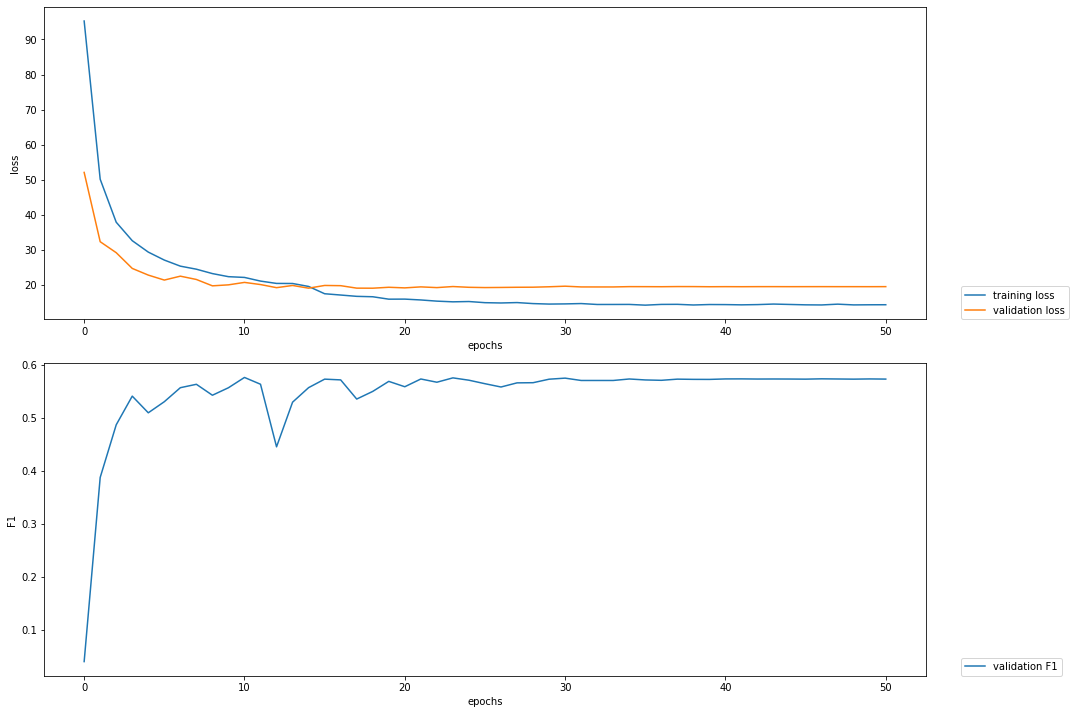

Weights plots are saved in ../../../media/nas_mount/Zaki/keyphrase_IP/models/inspec/weights.png


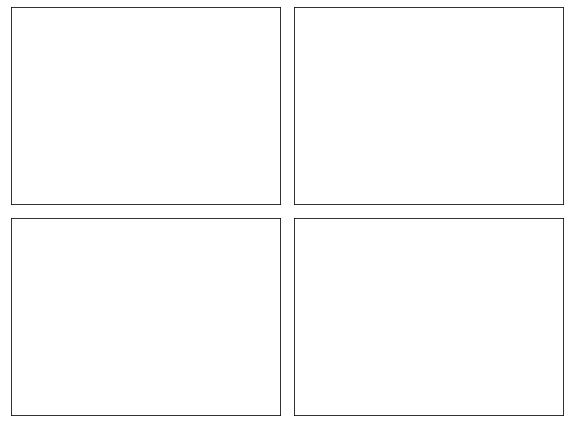

In [22]:
plot_curves(path)

In [14]:
'''model evaluation'''
print("--train evaluation")
result, _ = tagger.evaluate(corpus.train)
print(result.detailed_results)

print("\n--test evaluation")
result, _ = tagger.evaluate(corpus.test)
print(result.detailed_results)

--train evaluation

Results:
- F1-score (micro) 0.7793
- F1-score (macro) 0.7793

By class:
KEY        tp: 7886 - fp: 2563 - fn: 1904 - precision: 0.7547 - recall: 0.8055 - f1-score: 0.7793

--test evaluation

Results:
- F1-score (micro) 0.5799
- F1-score (macro) 0.5799

By class:
KEY        tp: 2844 - fp: 2120 - fn: 2000 - precision: 0.5729 - recall: 0.5871 - f1-score: 0.5799


## Training on Semeval 2010

In [28]:
corpus = get_corpus("semeval_2010")

tag_dictionary = get_tag_dictionary(corpus, tag_type="keyword")

embeddings = get_embeddings('bert-base-uncased')

tagger = initialize_model(tag_type="keyword")

2020-10-11 21:29:28,704 Reading data from /home/zaki/.flair/datasets/semeval2010
2020-10-11 21:29:28,705 Train: /home/zaki/.flair/datasets/semeval2010/train.txt
2020-10-11 21:29:28,706 Dev: None
2020-10-11 21:29:28,707 Test: /home/zaki/.flair/datasets/semeval2010/test.txt
Dictionary with 8 tags: <unk>, O, B-KEY, E-KEY, S-KEY, I-KEY, <START>, <STOP>


In [29]:
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

trainer.train('../../../media/nas_mount/Zaki/keyphrase_IP/models/semeval_2010/',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

2020-10-11 21:29:39,164 ----------------------------------------------------------------------------------------------------
2020-10-11 21:29:39,169 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): TransformerWordEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear

2020-10-11 21:29:39,171 ----------------------------------------------------------------------------------------------------
2020-10-11 21:29:39,172 Corpus: "Corpus: 130 train + 14 dev + 100 test sentences"
2020-10-11 21:29:39,173 ----------------------------------------------------------------------------------------------------
2020-10-11 21:29:39,173 Parameters:
2020-10-11 21:29:39,174  - learning_rate: "0.1"
2020-10-11 21:29:39,176  - mini_batch_size: "32"
2020-10-11 21:29:39,177  - patience: "3"
2020-10-11 21:29:39,177  - anneal_factor: "0.5"
2020-10-11 21:29:39,179  - max_epochs: "150"
2020-10-11 21:29:39,180  - shuffle: "True"
2020-10-11 21:29:39,181  - train_with_dev: "False"
2020-10-11 21:29:39,182  - batch_growth_annealing: "False"
2020-10-11 21:29:39,183 ----------------------------------------------------------------------------------------------------
2020-10-11 21:29:39,183 Model training base path: "../../../media/nas_mount/Zaki/keyphrase_IP/models/semeval_2010"
2020-10-

2020-10-11 21:30:47,858 epoch 8 - iter 3/5 - loss 51.99637985 - samples/sec: 40.33 - lr: 0.100000
2020-10-11 21:30:48,515 epoch 8 - iter 4/5 - loss 52.50677204 - samples/sec: 48.79 - lr: 0.100000
2020-10-11 21:30:48,851 epoch 8 - iter 5/5 - loss 55.49375381 - samples/sec: 95.76 - lr: 0.100000
2020-10-11 21:30:48,852 ----------------------------------------------------------------------------------------------------
2020-10-11 21:30:48,853 EPOCH 8 done: loss 55.4938 - lr 0.1000000
2020-10-11 21:30:49,064 DEV : loss 47.36848068237305 - score 0.0465
2020-10-11 21:30:49,071 BAD EPOCHS (no improvement): 0
saving best model
2020-10-11 21:30:54,038 ----------------------------------------------------------------------------------------------------
2020-10-11 21:30:54,956 epoch 9 - iter 1/5 - loss 44.17630005 - samples/sec: 35.15 - lr: 0.100000
2020-10-11 21:30:55,706 epoch 9 - iter 2/5 - loss 43.26490593 - samples/sec: 42.81 - lr: 0.100000
2020-10-11 21:30:56,304 epoch 9 - iter 3/5 - loss 46.

2020-10-11 21:31:41,756 epoch 17 - iter 1/5 - loss 37.62409592 - samples/sec: 39.65 - lr: 0.100000
2020-10-11 21:31:42,533 epoch 17 - iter 2/5 - loss 38.46201897 - samples/sec: 41.30 - lr: 0.100000
2020-10-11 21:31:43,204 epoch 17 - iter 3/5 - loss 36.68628565 - samples/sec: 47.74 - lr: 0.100000
2020-10-11 21:31:43,993 epoch 17 - iter 4/5 - loss 36.57799625 - samples/sec: 40.64 - lr: 0.100000
2020-10-11 21:31:44,280 epoch 17 - iter 5/5 - loss 36.79268265 - samples/sec: 112.18 - lr: 0.100000
2020-10-11 21:31:44,281 ----------------------------------------------------------------------------------------------------
2020-10-11 21:31:44,281 EPOCH 17 done: loss 36.7927 - lr 0.1000000
2020-10-11 21:31:44,517 DEV : loss 38.01031494140625 - score 0.1481
2020-10-11 21:31:44,524 BAD EPOCHS (no improvement): 3
2020-10-11 21:31:44,526 ----------------------------------------------------------------------------------------------------
2020-10-11 21:31:45,130 epoch 18 - iter 1/5 - loss 30.24848175 -

2020-10-11 21:32:13,250 EPOCH 25 done: loss 29.3024 - lr 0.0250000
2020-10-11 21:32:13,524 DEV : loss 38.40655517578125 - score 0.2329
2020-10-11 21:32:13,532 BAD EPOCHS (no improvement): 3
2020-10-11 21:32:13,557 ----------------------------------------------------------------------------------------------------
2020-10-11 21:32:14,323 epoch 26 - iter 1/5 - loss 26.93565369 - samples/sec: 41.87 - lr: 0.025000
2020-10-11 21:32:15,089 epoch 26 - iter 2/5 - loss 26.20246506 - samples/sec: 41.84 - lr: 0.025000
2020-10-11 21:32:15,910 epoch 26 - iter 3/5 - loss 27.24797567 - samples/sec: 39.04 - lr: 0.025000
2020-10-11 21:32:16,614 epoch 26 - iter 4/5 - loss 26.48312187 - samples/sec: 45.53 - lr: 0.025000
2020-10-11 21:32:16,916 epoch 26 - iter 5/5 - loss 27.29388275 - samples/sec: 106.60 - lr: 0.025000
2020-10-11 21:32:16,917 ----------------------------------------------------------------------------------------------------
2020-10-11 21:32:16,918 EPOCH 26 done: loss 27.2939 - lr 0.02500

2020-10-11 21:32:44,721 epoch 34 - iter 4/5 - loss 24.96411705 - samples/sec: 47.79 - lr: 0.006250
2020-10-11 21:32:45,237 epoch 34 - iter 5/5 - loss 27.51824799 - samples/sec: 62.19 - lr: 0.006250
2020-10-11 21:32:45,238 ----------------------------------------------------------------------------------------------------
2020-10-11 21:32:45,239 EPOCH 34 done: loss 27.5182 - lr 0.0062500
2020-10-11 21:32:45,505 DEV : loss 36.60701370239258 - score 0.2358
Epoch    34: reducing learning rate of group 0 to 3.1250e-03.
2020-10-11 21:32:45,513 BAD EPOCHS (no improvement): 4
2020-10-11 21:32:45,534 ----------------------------------------------------------------------------------------------------
2020-10-11 21:32:46,243 epoch 35 - iter 1/5 - loss 24.29216003 - samples/sec: 45.21 - lr: 0.003125
2020-10-11 21:32:47,053 epoch 35 - iter 2/5 - loss 24.76388741 - samples/sec: 39.61 - lr: 0.003125
2020-10-11 21:32:47,673 epoch 35 - iter 3/5 - loss 24.63071632 - samples/sec: 51.71 - lr: 0.003125
202

2020-10-11 21:33:14,311 epoch 43 - iter 1/5 - loss 24.87596893 - samples/sec: 49.18 - lr: 0.000781
2020-10-11 21:33:14,989 epoch 43 - iter 2/5 - loss 24.74125481 - samples/sec: 47.26 - lr: 0.000781
2020-10-11 21:33:15,809 epoch 43 - iter 3/5 - loss 24.97556686 - samples/sec: 39.09 - lr: 0.000781
2020-10-11 21:33:16,540 epoch 43 - iter 4/5 - loss 25.01512146 - samples/sec: 43.84 - lr: 0.000781
2020-10-11 21:33:16,877 epoch 43 - iter 5/5 - loss 23.49097900 - samples/sec: 95.14 - lr: 0.000781
2020-10-11 21:33:16,878 ----------------------------------------------------------------------------------------------------
2020-10-11 21:33:16,879 EPOCH 43 done: loss 23.4910 - lr 0.0007813
2020-10-11 21:33:17,122 DEV : loss 36.63701629638672 - score 0.2424
2020-10-11 21:33:17,128 BAD EPOCHS (no improvement): 1
2020-10-11 21:33:17,131 ----------------------------------------------------------------------------------------------------
2020-10-11 21:33:17,777 epoch 44 - iter 1/5 - loss 22.91082954 - 

2020-10-11 21:33:45,115 EPOCH 51 done: loss 23.0107 - lr 0.0001953
2020-10-11 21:33:45,342 DEV : loss 36.65621566772461 - score 0.2424
2020-10-11 21:33:45,348 BAD EPOCHS (no improvement): 1
2020-10-11 21:33:45,350 ----------------------------------------------------------------------------------------------------
2020-10-11 21:33:46,069 epoch 52 - iter 1/5 - loss 22.49002075 - samples/sec: 44.59 - lr: 0.000195
2020-10-11 21:33:47,221 epoch 52 - iter 2/5 - loss 23.84107208 - samples/sec: 27.80 - lr: 0.000195
2020-10-11 21:33:48,029 epoch 52 - iter 3/5 - loss 25.27560679 - samples/sec: 39.67 - lr: 0.000195
2020-10-11 21:33:48,633 epoch 52 - iter 4/5 - loss 24.67177677 - samples/sec: 53.03 - lr: 0.000195
2020-10-11 21:33:49,153 epoch 52 - iter 5/5 - loss 31.16476517 - samples/sec: 61.80 - lr: 0.000195
2020-10-11 21:33:49,155 ----------------------------------------------------------------------------------------------------
2020-10-11 21:33:49,156 EPOCH 52 done: loss 31.1648 - lr 0.000195

{'test_score': 0.29355149181905676,
 'dev_score_history': [0.0,
  0.0,
  0.0,
  0.0,
  0.022222222222222223,
  0.013157894736842105,
  0.02127659574468085,
  0.046511627906976744,
  0.034090909090909095,
  0.034883720930232565,
  0.22727272727272724,
  0.13471502590673576,
  0.25225225225225223,
  0.2828282828282829,
  0.08,
  0.09322033898305085,
  0.14814814814814814,
  0.09638554216867469,
  0.23236514522821577,
  0.2,
  0.23809523809523808,
  0.2136752136752137,
  0.19534883720930232,
  0.2469135802469136,
  0.23293172690763053,
  0.2723735408560311,
  0.20091324200913238,
  0.25,
  0.2368421052631579,
  0.25296442687747034,
  0.25210084033613445,
  0.23580786026200876,
  0.23376623376623376,
  0.23580786026200876,
  0.23111111111111113,
  0.2300884955752212,
  0.25,
  0.25,
  0.24242424242424238,
  0.24242424242424238,
  0.24242424242424238,
  0.24892703862660942,
  0.24242424242424238,
  0.24242424242424238,
  0.24242424242424238,
  0.24242424242424238,
  0.24242424242424238,
  0

In [30]:
'''testing the model for sample sentence'''
path='../../../media/nas_mount/Zaki/keyphrase_IP/models/semeval_2010/'
model = SequenceTagger.load(path + "best-model.pt")

sentence = corpus.test[0].to_tagged_string('text')
print("\n\n-------Input sentence------------")
print(sentence)

sentence = Sentence(sentence)
# predict tags and print
model.predict(sentence)
print("\n\n--------tag predictions for input sentence----------")
print(sentence.to_tagged_string())

2020-10-11 21:36:12,478 loading file ../../../media/nas_mount/Zaki/keyphrase_IP/models/semeval_2010/best-model.pt


-------Input sentence------------
A High-Accuracy , Low-Cost Localization System for Wireless Sensor Networks ABSTRACT The problem of localization of wireless sensor nodes has long been regarded as very difficult to solve , when considering the realities of real world environments . In this paper , we formally describe , design , implement and evaluate a novel localization system , called Spotlight . Our system uses the spatio-temporal properties of well controlled events in the network -LRB- e.g. , light -RRB- , to obtain the locations of sensor nodes . We demonstrate that a high accuracy in localization can be achieved without the aid of expensive hardware on the sensor nodes , as required by other localization systems . We evaluate the performance of our system in deployments of Mica2 and XSM motes . Through performance evaluations of a real system deployed outdoors , 

2020-10-11 21:36:22,677 ----------------------------------------------------------------------------------------------------
2020-10-11 21:36:22,679 WARNING: No LOSS found for test split in this data.
2020-10-11 21:36:22,680 Are you sure you want to plot LOSS and not another value?
2020-10-11 21:36:22,682 ----------------------------------------------------------------------------------------------------
2020-10-11 21:36:22,710 ----------------------------------------------------------------------------------------------------
2020-10-11 21:36:22,711 WARNING: No F1 found for test split in this data.
2020-10-11 21:36:22,712 Are you sure you want to plot F1 and not another value?
2020-10-11 21:36:22,712 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in ../../../media/nas_mount/Zaki/keyphrase_IP/models/semeval_2010/training.png


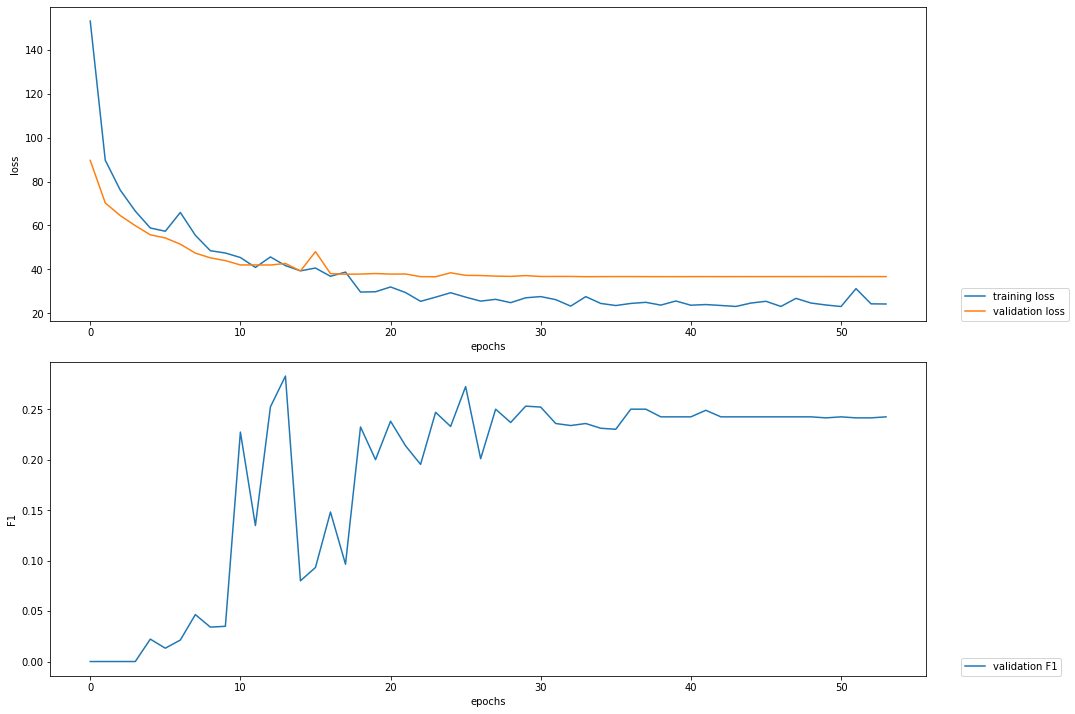

Weights plots are saved in ../../../media/nas_mount/Zaki/keyphrase_IP/models/semeval_2010/weights.png


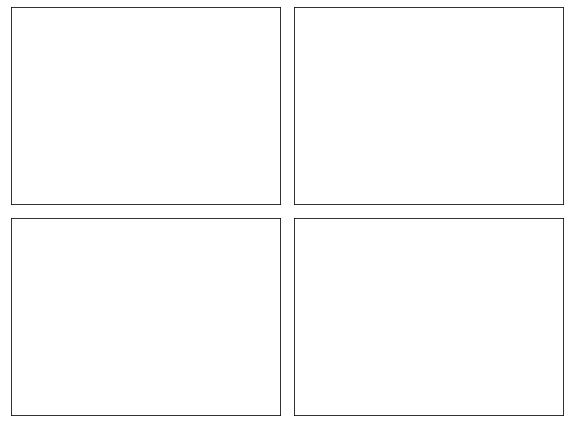

In [31]:
plot_curves(path)

In [32]:
'''model evaluation'''
print("--train evaluation")
result, _ = tagger.evaluate(corpus.train)
print(result.detailed_results)

print("\n--test evaluation")
result, _ = tagger.evaluate(corpus.test)
print(result.detailed_results)

--train evaluation

Results:
- F1-score (micro) 0.6256
- F1-score (macro) 0.6256

By class:
KEY        tp: 716 - fp: 289 - fn: 568 - precision: 0.7124 - recall: 0.5576 - f1-score: 0.6256

--test evaluation

Results:
- F1-score (micro) 0.2882
- F1-score (macro) 0.2882

By class:
KEY        tp: 244 - fp: 465 - fn: 740 - precision: 0.3441 - recall: 0.2480 - f1-score: 0.2882


In [6]:
### load dataset for visualization
path = "../../../media/nas_mount/Zaki/keyphrase_IP/datasets/inspec/train.txt"

dataset = pd.read_csv(path, delim_whitespace=True, header=None)
dataset

,0,1
0,Knowledge,B-KEY
1,management,I-KEY
2,The,O
3,article,O
4,defines,O
...,...,...
141503,will,O
141504,move,O
141505,towards,O
141506,these,O


In [59]:
corpus.train[1].to_tagged_string('text')

'High-level language support for user-defined reductions The optimized handling of reductions on parallel supercomputers or clusters of workstations is critical to high performance because reductions are common in scientific codes and a potential source of bottlenecks . Yet in many high-level languages , a mechanism for writing efficient reductions remains surprisingly absent . Further , when such mechanisms do exist , they often do not provide the flexibility a programmer needs to achieve a desirable level of performance . In this paper , we present a new language construct for arbitrary reductions that lets a programmer achieve a level of performance equal to that achievable with the highly flexible , but low-level combination of Fortran and MPI . We have implemented this construct in the ZPL language and evaluate it in the context of the initialization of the NAS MG benchmark . We show a 45 times speedup over the same code written in ZPL without this construct . In addition , perfor

In [55]:
corpus.train.column_name_map

{0: 'text', 1: 'keyword'}

In [60]:
corpus.make_label_dictionary('keyword')

2020-10-10 23:52:34,774 Computing label dictionary. Progress:


100%|██████████| 1500/1500 [00:00<00:00, 7255.98it/s]

2020-10-10 23:52:34,991 [b'B-KEY', b'E-KEY', b'O', b'S-KEY', b'I-KEY']
